# Classification of Pulsar Stars From the HTRU2 Data Set

## Introduction

This dataset classifies neutron stars as pulsars or non-pulsars. Pulsars are a type of neutron star that play important roles as probes of space-time, inter-stellar mediums, and a variety of other uses of scientific interest. The data for the stars comes from the HTRU (High Time Resolution Universe) Survey. The pulsars are detected through periodic radio signals that have slight different emission patterns. However, sometimes detections of periodic radio signals are a result of RFI (radio frequency interference) and noise. This dataset sorts profile attributes into mean of integrated profile (averages emission atters of periodic radio signals over many rotations), standard deviation of profiles, along with DM-SNR data to classify whether the signals were caused by pulsars or non-pulsars.

Our project then aims to answer the question: **Can we use measurements from signal profiles to predict whether a future signal (of unknown class) is a result of a pulsar or non-pulsar?**

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

## Preliminary exploratory data analysis

In [1]:
# Loading in packages
library(tidyverse) # Meta package for reading and wrangling data
library(repr) # For effective data visualizations
library(tidymodels) # For classification and training

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Read the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "pulsardata.zip") 
unzip("pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9))
colnames(pulsar_data) <- make.names(c("Mean of integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))
pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [3]:
# Clean and wrangle the data

In [4]:
# Summarize the data

In [5]:
# Visualization

## Methods

**Explain how you will conduct either your data analysis and which variables/columns you will use.
Describe at least one way that you will visualize the results.**

We will conduct our data analysis by using the K-nearest neighbours classification algorithm and tune our classifier using 5-fold cross-validation. 

To determine which variables/columns we'll use, we must first compare the differences in distribution of our classification category in context of each variable. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



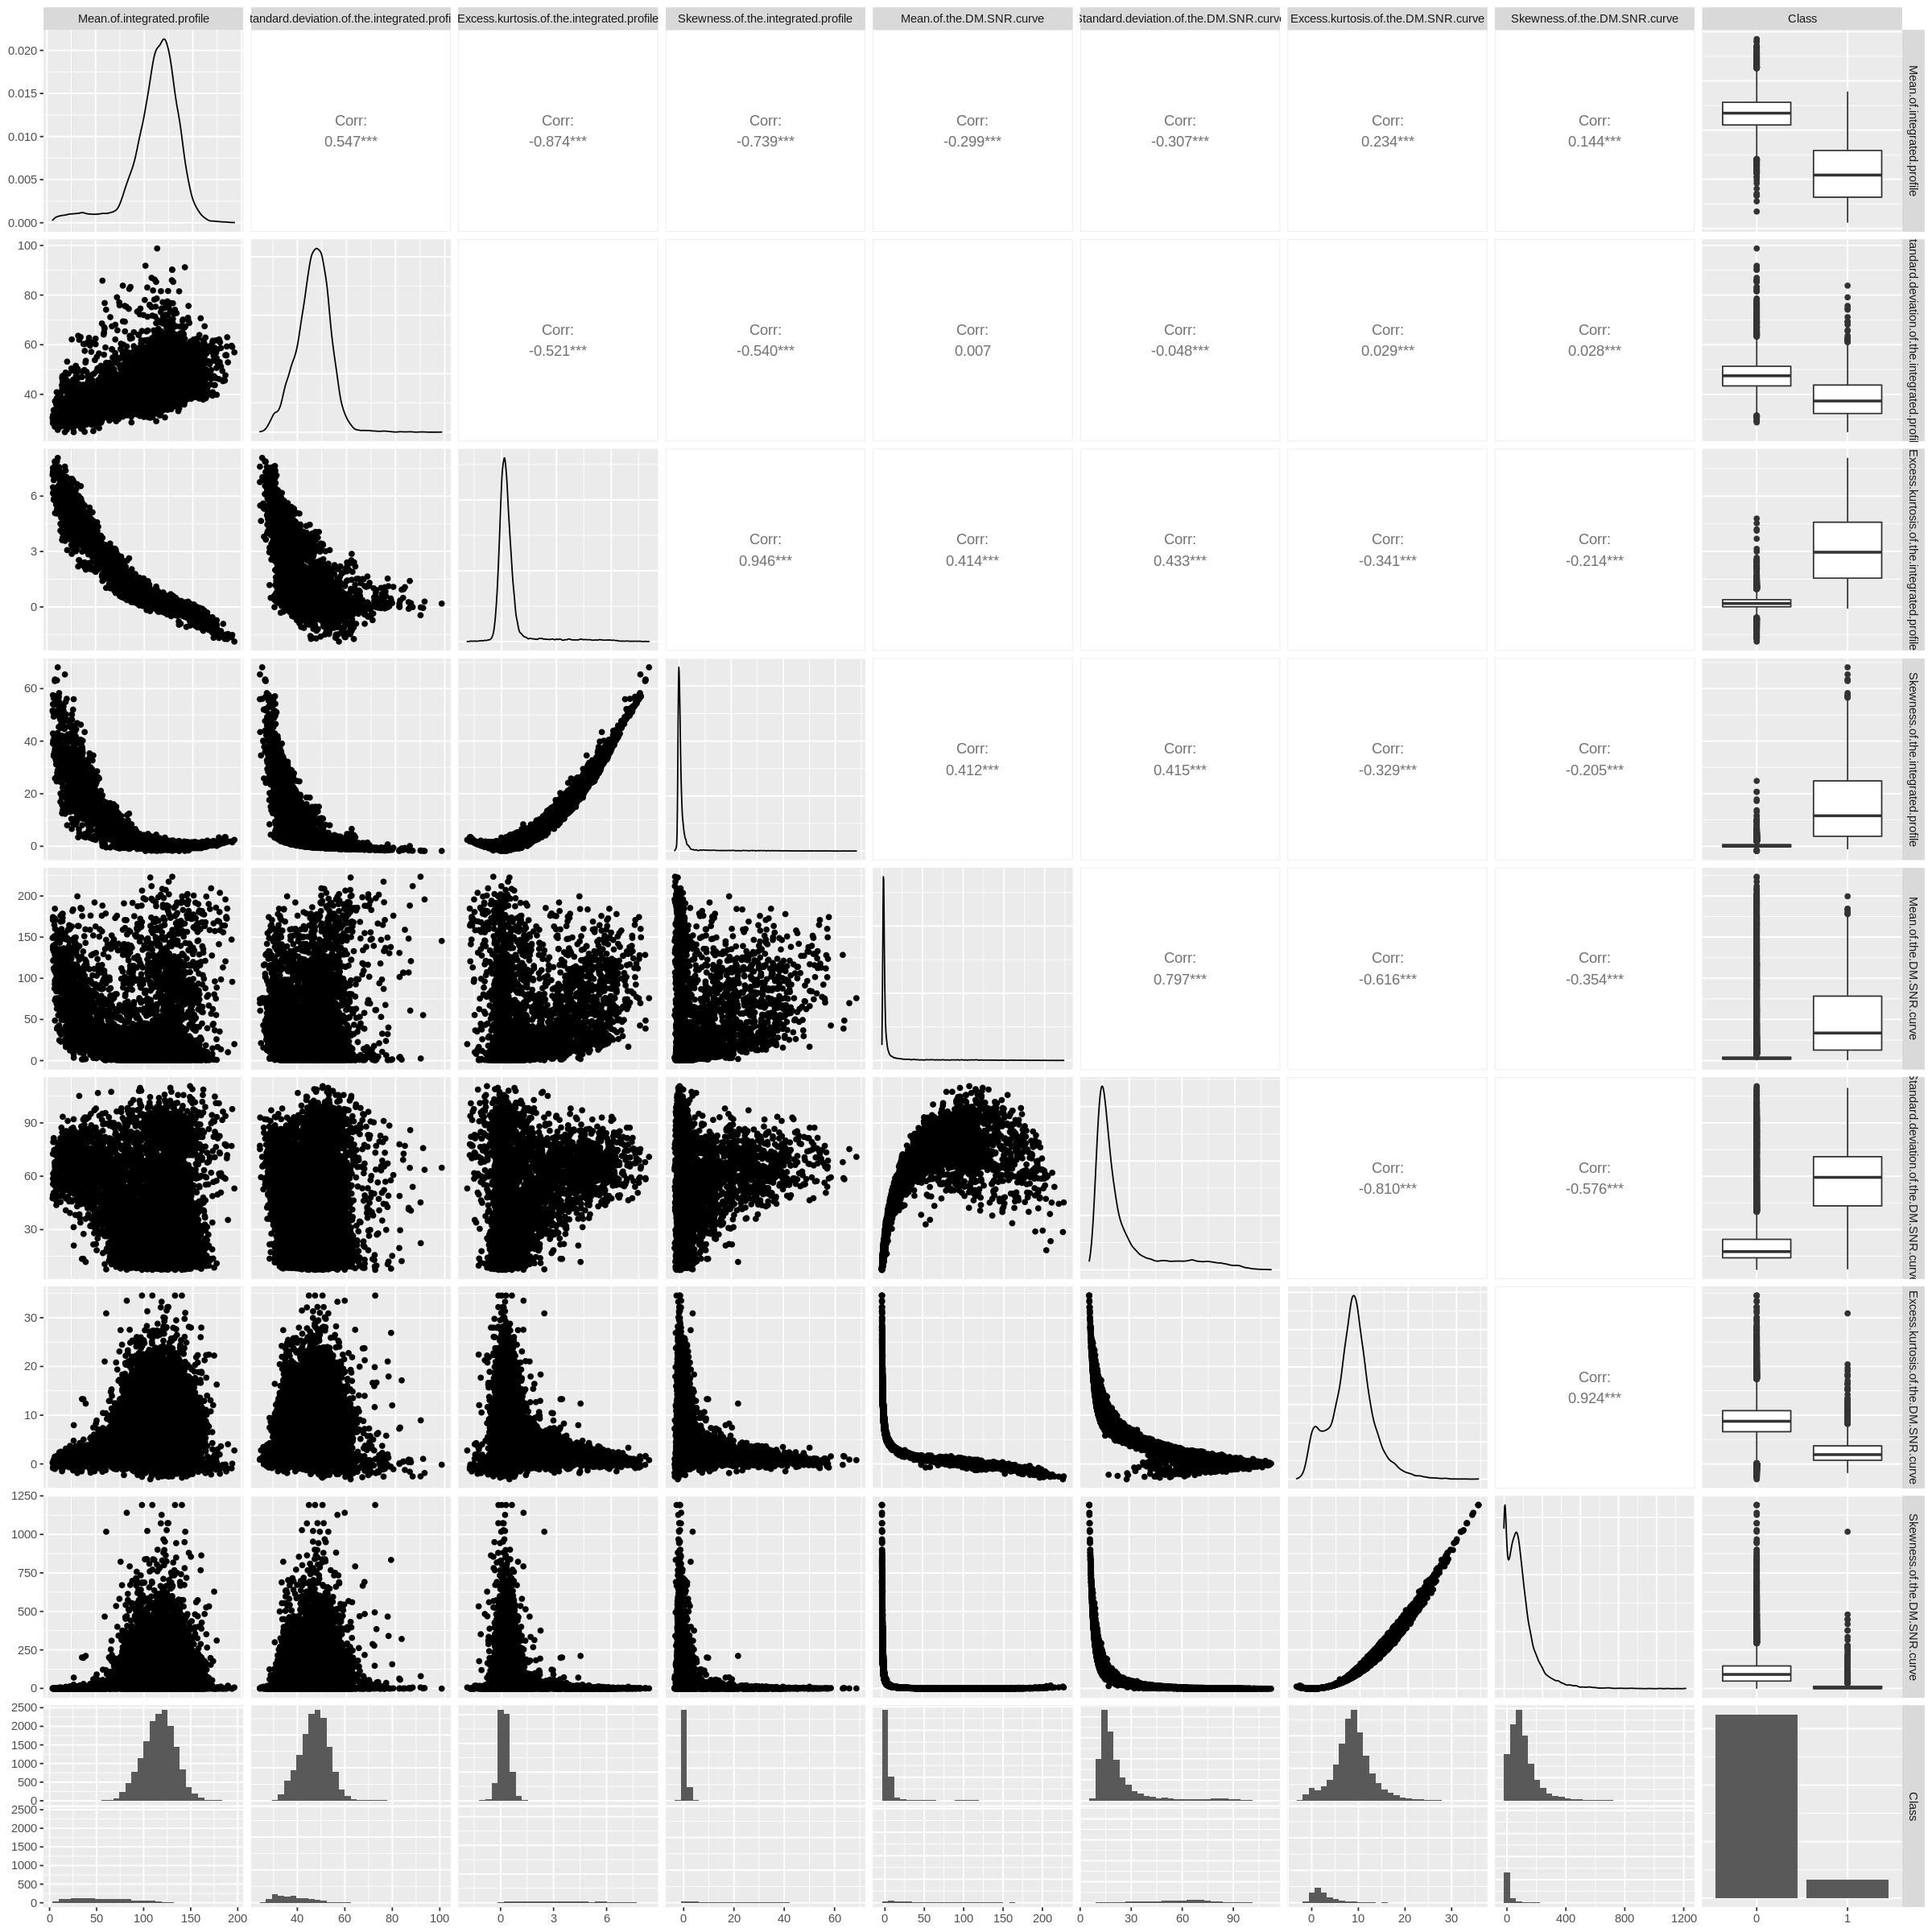

In [10]:
library(GGally)
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(pulsar_data)

As seen in the rightmost column, each of the variables in this dataframe will be useful for our data analysis to determine whether or not the signal profile is a pulsar. This is due to the mean and deviation between the two classes differing across each variable.

We will visualise our data analysis using a line plot for our 5-fold cross-validation and a confusion matric to analyse the accuracy of our final classifier. 

## Expected outcomes and significance